# CS4 Processing Report



### Package versions

In [1]:
import paramaterial as pam
from paramaterial import DataSet, DataItem
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

print('paramaterial', pam.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('matplotlib', mpl.__version__)

paramaterial 0.1.0
numpy 1.23.5
pandas 1.5.3
matplotlib 3.7.0


## Data preparation

In [2]:
pam.check_column_headers('data/01 raw data', exception_headers=['TC4(C)', 'Stroke(mm)', 'wedge(mm)'])
pam.check_for_duplicate_files('data/01 raw data')

Checking column headers...
First file headers:
	['Time(sec)', 'Force(kN)', 'Jaw(mm)', 'PowAngle(deg)', 'PTemp', 'Strain', 'Stress(MPa)', 'TC1(C)', 'TC2(C)', 'TC3(C)', 'TC4(C)']
Headers in all files are the same as in the first file, except for ['TC4(C)', 'Stroke(mm)', 'wedge(mm)'].
Checking for duplicate files...
No duplicate files found in "data/01 raw data".


Load the data and info into a dataset object (ds is shorthand for dataset).

In [3]:
raw_ds = DataSet('info/01 raw info.xlsx', 'data/01 raw data').sort_by(['test type', 'temperature'])

### Make the experimental matrix
The tests can be grouped by nominal rate, nominal temperature, and test type. We will make the classic rate-temperature matrices - one for each test type.

In [4]:
gold_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", (85 / 255, 49 / 255, 0)])
mpl.rcParams['axes.facecolor'] = gold_cmap(0.1)

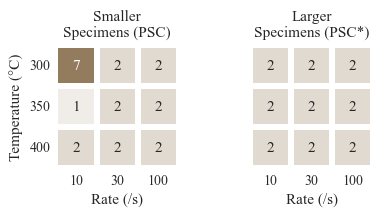

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(4.6, 1.6))
heatmap_kwargs = dict(linewidths=4, cbar=False, annot=True, cmap=gold_cmap, vmin=0, vmax=11)

pam.experimental_matrix(raw_ds.subset({'test type': 'PSC'}).info_table,
                        index='temperature', columns='rate', as_heatmap=True, title='Smaller\nSpecimens (PSC)',
                        xlabel='Rate (/s)', ylabel='Temperature (°C)',
                        tick_params=dict(rotation=0), ax=axs[0], **heatmap_kwargs)

pam.experimental_matrix(raw_ds.subset({'test type': 'PSC*'}).info_table,
                        index='temperature', columns='rate', as_heatmap=True, title='Larger\nSpecimens (PSC*)',
                        xlabel='Rate (/s)', ylabel=' ',
                        tick_params=dict(labelleft=False), ax=axs[1], **heatmap_kwargs);

### Setup plotting
Now that we know how to group the data, we can set up a plotting function.

In [6]:
styler = pam.plotting.Styler(color_by='temperature', color_by_label='(°C)', cmap='plasma',
                             color_norm=plt.Normalize(300, 500)
                             ).style_to(raw_ds)


def ds_subplot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(
        ds, shape=(2, 3), figsize=(8, 3.5),
        cols_by='rate', rows_by='test type',
        col_vals=[[10], [30], [100]], row_vals=[['PSC'], ['PSC*']],
        col_titles=['10 /s', '30 /s', '100/s'], row_titles=['Smaller Specimens', 'Larger Specimens'],
        styler=styler, plot_legend=False, subplot_legend=False,
        **kwargs
    )


stress_strain_labels = dict(x='Strain', y='Stress(MPa)', xlabel='Strain', ylabel='Stress (MPa)')

Plot the raw data.

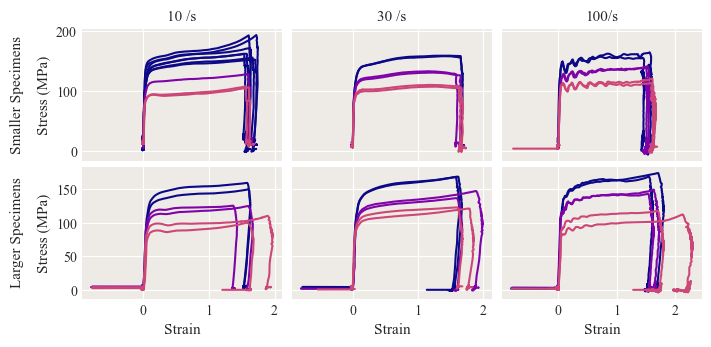

In [7]:
ds_subplot(raw_ds, **stress_strain_labels);

## Data processing

### Trim data

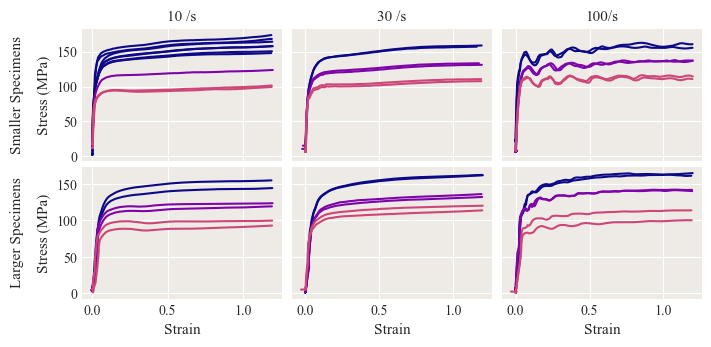

In [8]:
def drop_columns(di: DataItem) -> DataItem:
    for column in ['PowAngle(deg)', 'Power(W)', 'Pram', 'PTemp', 'Stroke(mm)', 'wedge(mm)']:
        if column in di.data.columns:
            di.data = di.data.drop(columns=[column])
    return di


def trim_using_time_step(di: DataItem) -> DataItem:
    t_diff = np.diff(di.data['Time(sec)'])
    di.data['time diff'] = np.hstack([t_diff[0], t_diff])
    di.data = di.data[di.data['time diff'] < 0.02][1:]
    return di


def remove_trailing_data(di: DataItem):
    di.data = di.data[di.data['Strain'] < 1.2]
    return di


trimmed_ds = raw_ds.apply(drop_columns).apply(trim_using_time_step).apply(remove_trailing_data)
ds_subplot(trimmed_ds, **stress_strain_labels);

### Find flow stress values
Determine the stress, temperature for each test. Note that while nominal temperature is given, the actual test conditions are slightly different. The actual strain-rate does not differ significantly from the nominal rate for these tests.

In [9]:
rates_ds = pam.calculate_strain_rate(trimmed_ds, time_key='Time(sec)')

processed_ds = pam.find_flow_stress_values(rates_ds, flow_strain=(0.8, 0.9),
                                           stress_key='Stress(MPa)', temperature_key='TC1(C)', rate_key='Strain_Rate'
                                           ).sort_by('rate')

In [10]:
processed_ds.write_output('info/02 processed info.xlsx', 'data/02 processed data')

### Make representative curves

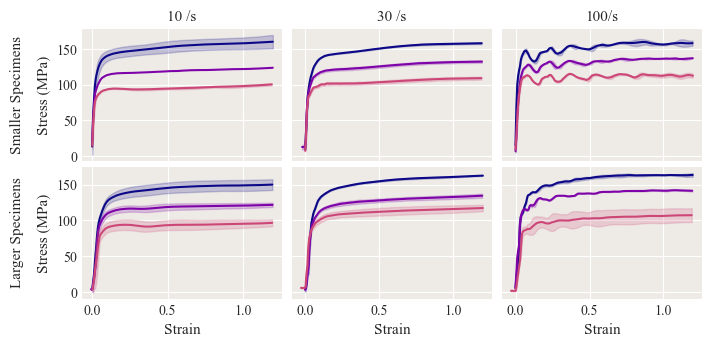

In [22]:
pam.make_representative_data(processed_ds, 'info/03 repr trim info.xlsx', 'data/03 repr trim data',
                             repres_col='Stress(MPa)', group_by_keys=['temperature', 'test type', 'rate'],
                             interp_by='Strain', group_info_cols=['flow_Stress(MPa)', 'flow_TC1(C)'])

repr_ds = DataSet('info/03 repr trim info.xlsx', 'data/03 repr trim data', test_id_key='repres_id').sort_by(
    'temperature')

ds_subplot(repr_ds, x='Strain', y='Stress(MPa)', xlabel='Strain', ylabel='Stress (MPa)',
           fill_between=('down_std_Stress(MPa)', 'up_std_Stress(MPa)'));

### Zener-Holloman Analysis

In [23]:
default_cmap = plt.cm.get_cmap('RdYlGn')
colors = default_cmap(np.arange(default_cmap.N))
colors[0] = (1, 1, 1, 1)
custom_cmap = mpl.colors.ListedColormap(colors)


def conformance_matrix(_ds: DataSet):
    fig, axs = plt.subplots(1, 2, figsize=(4.6, 1.6))
    heatmap_kwargs = dict(linewidths=4, cbar=False, annot=True, fmt='.1f', cmap=custom_cmap, vmin=85, vmax=100)
    pam.make_quality_matrix(_ds.subset({'test type': 'PSC'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='Smaller Specimens (PSC)',
                            xlabel='Rate (/s)', ylabel='Temperature (°C)', tick_params=dict(rotation=0), ax=axs[0],
                            **heatmap_kwargs)
    pam.make_quality_matrix(_ds.subset({'test type': 'PSC*'}).info_table, index='temperature', columns='rate',
                            flow_stress_key='flow_Stress(MPa)', as_heatmap=True, title='Larger Specimens (PSC*)',
                            xlabel='Rate (/s)', ylabel=' ', tick_params=dict(labelleft=False), ax=axs[1],
                            **heatmap_kwargs)

C:\Users\DS\AppData\Local\Temp\ipykernel_17428\3790203181.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  default_cmap = plt.cm.get_cmap('RdYlGn')


In [24]:
info_table = processed_ds.info_table
info_table['Q_activation'] = 155000.
info_table['flow_temp(K)'] = info_table['flow_TC1(C)'] + 273.15
processed_ds.info_table = info_table
analysis_ds = processed_ds.apply(pam.calculate_ZH_parameter, rate_key='flow_Strain_Rate',
                                 temperature_key='flow_temp(K)')

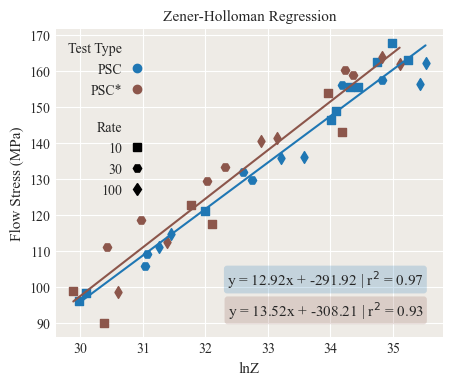

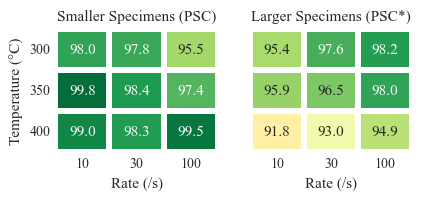

In [25]:
type_analysis_ds = pam.apply_ZH_regression(analysis_ds.copy(), flow_stress_key='flow_Stress(MPa)', group_by='test type')
ax = pam.plot_ZH_regression(type_analysis_ds, group_by='test type', color_by='test type', marker_by='rate',
                            cmap='tab20',
                            flow_stress_key='flow_Stress(MPa)', rate_key='flow_Strain_Rate',
                            temperature_key='flow_temp(K)', figsize=(5, 4), eq_hscale=0.1)
conformance_matrix(type_analysis_ds)

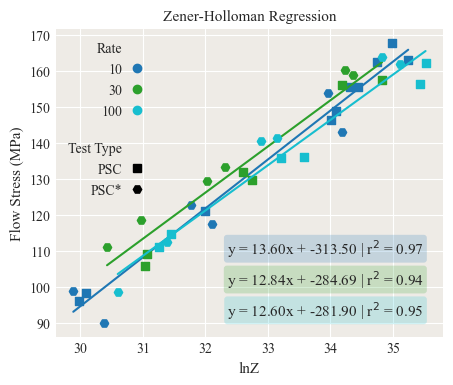

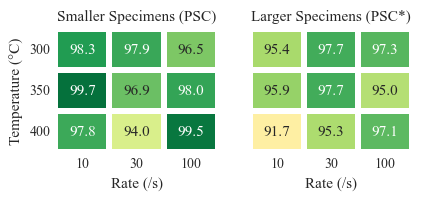

In [26]:
rate_analysis_ds = pam.apply_ZH_regression(analysis_ds.copy(), flow_stress_key='flow_Stress(MPa)', group_by='rate')
ax = pam.plot_ZH_regression(rate_analysis_ds, group_by='rate',
                            color_by='rate', marker_by='test type', cmap='tab10',
                            flow_stress_key='flow_Stress(MPa)', rate_key='flow_Strain_Rate',
                            temperature_key='flow_temp(K)', figsize=(5, 4), eq_hscale=0.1)
conformance_matrix(rate_analysis_ds)

### Tables

In [27]:
df = pam.make_representative_info(type_analysis_ds, group_by_keys=['test type', 'rate', 'temperature'],
                                  group_info_cols=['lnZ_fit_residual', 'lnZ', 'ZH_parameter', 'flow_TC1(C)',
                                                   'flow_Stress(MPa)'])
table = df[['test type', 'rate', 'temperature', 'flow_Stress(MPa)', 'flow_TC1(C)', 'ZH_parameter', 'lnZ']].sort_values(
    ['temperature', 'test type'])
table = table.reset_index().drop(columns=['index'])
table = table[['temperature', 'test type', 'rate', 'flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']]
table_s10 = table[table['rate'] == 10].drop(columns=['rate'])
table_s30 = table[table['rate'] == 30].drop(columns=['rate'])
table_s100 = table[table['rate'] == 100].drop(columns=['rate'])

In [28]:
for col in ['flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']:
    table_s10[col] = table_s10[col].apply(lambda x: f'{x:.3g}')

table_s10.style.to_latex('info/s10_table.tex')

In [29]:
for col in ['flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']:
    table_s30[col] = table_s30[col].apply(lambda x: f'{x:.3g}')

table_s30.style.to_latex('info/s30_table.tex')

In [30]:
for col in ['flow_Stress(MPa)', 'flow_TC1(C)', 'lnZ']:
    table_s100[col] = table_s100[col].apply(lambda x: f'{x:.3g}')

table_s100.to_latex('info/s100_table.tex')

C:\Users\DS\AppData\Local\Temp\ipykernel_17428\2753916990.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_s100.to_latex('info/s100_table.tex')


## Dan MSc Figures

### Figure 5.15

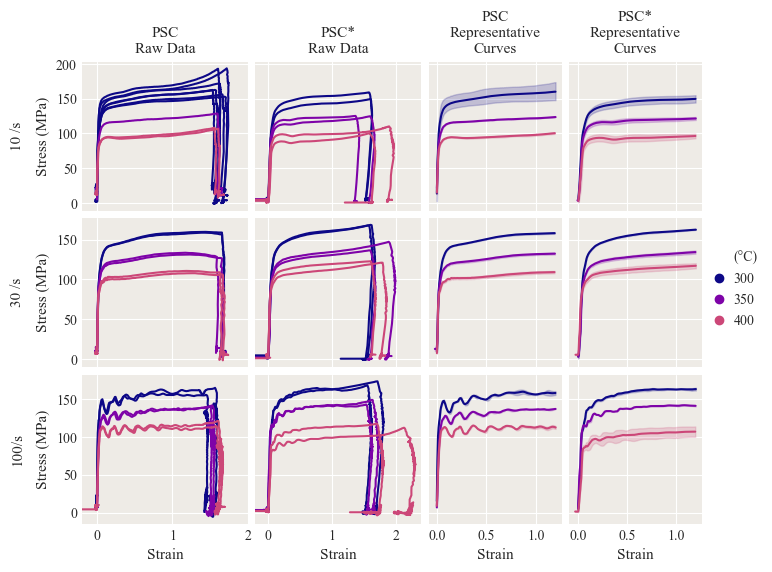

In [31]:
fig, axs = plt.subplots(3, 4, figsize=(8, 6), sharex='col', sharey='row',
                        gridspec_kw={'width_ratios': [2.5, 2.5, 2, 2]})


def ds_subplot2(ds: DataSet, ttype, **kwargs):
    mpl.rcParams['axes.facecolor'] = gold_cmap(0.1)
    return pam.plotting.dataset_subplots(
        ds, shape=(3, 1), figsize=(3, 6),
        rows_by='rate', cols_by='test type',
        row_vals=[[10], [30], [100]], col_vals=[[ttype]],
        row_titles=['10 /s', '30 /s', '100/s'],
        styler=styler, plot_legend=False, subplot_legend=False, **kwargs
    )


def ds_subplot3(ds: DataSet, ttype, **kwargs):
    mpl.rcParams['axes.facecolor'] = gold_cmap(0.1)
    return pam.plotting.dataset_subplots(
        ds, shape=(3, 1), figsize=(3, 6),
        rows_by='rate', cols_by='test type',
        row_vals=[[10], [30], [100]], col_vals=[[ttype]],
        styler=styler, plot_legend=False, subplot_legend=False, **kwargs
    )


ds_subplot2(raw_ds.subset({'test type': 'PSC'}), 'PSC', axs=axs[:, 0], **stress_strain_labels)
ds_subplot3(repr_ds.subset({'test type': 'PSC'}), 'PSC', axs=axs[:, 2], **stress_strain_labels,
            fill_between=('min_Stress(MPa)', 'max_Stress(MPa)'))
ds_subplot3(raw_ds.subset({'test type': 'PSC*'}), 'PSC*', axs=axs[:, 1], **stress_strain_labels)
ds_subplot3(repr_ds.subset({'test type': 'PSC*'}), 'PSC*', axs=axs[:, 3], **stress_strain_labels,
            fill_between=('min_Stress(MPa)', 'max_Stress(MPa)'))

for ax in axs[:, 1:].flat:
    ax.set_ylabel('')
for ax, title in zip(axs[0, :].flat, ['PSC\nRaw Data', 'PSC*\nRaw Data', 'PSC\nRepresentative\nCurves',
                                      'PSC*\nRepresentative\nCurves']):
    ax.set_title(title)

axs[0, 0].set_xlim((-0.2, 2.0))
axs[0, 1].set_xlim((-0.2, 2.4))
handles = styler.legend_handles()
plt.subplots_adjust(right=0.9)
axs.flat[0].get_figure().legend(handles=handles, loc='center right',
                                bbox_to_anchor=(0.985, 0.5), handletextpad=0.005)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Figure 5.16

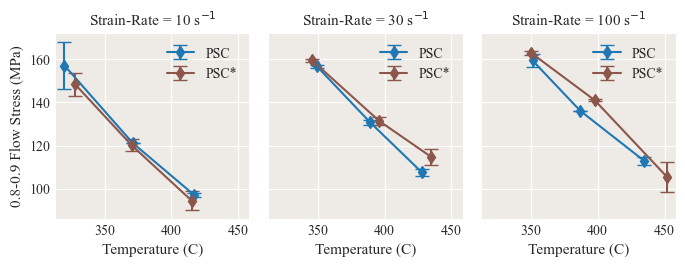

In [32]:
df = repr_ds.info_table

import matplotlib as mpl
colors = [(0.122, 0.467, 0.706), (0.549, 0.337, 0.294)]
fig, axs = plt.subplots(1, 3, figsize=(8, 2.4), sharey='all', sharex='all')

for i, rate in enumerate([10, 30, 100]):
    data = df[df['rate'] == rate]
    for c, ttype in enumerate(['PSC', 'PSC*']):
        mat_data = data[data['test type'] == ttype]
        axs[i].errorbar(mat_data['flow_TC1(C)'], mat_data['flow_Stress(MPa)'],
                        yerr=[mat_data['flow_Stress(MPa)'].values - mat_data['min_flow_Stress(MPa)'].values,
                              mat_data['max_flow_Stress(MPa)'].values - mat_data['flow_Stress(MPa)'].values],
                        label=ttype, capsize=5, marker='d', color=colors[c])
    axs[i].set(xlabel='Temperature (C)', ylabel='0.8-0.9 Flow Stress (MPa)', title=f'Strain-Rate = {rate} s$^{{-1}}$')
    axs[i].legend()

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.subplots_adjust(wspace=0.1)

### Figure 5.17

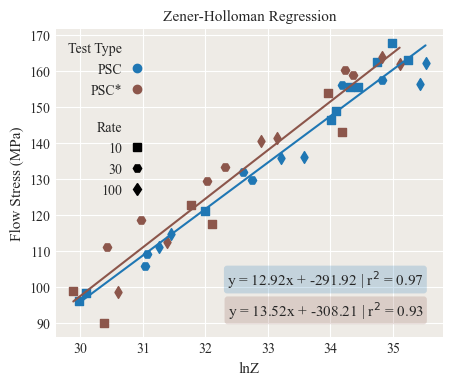

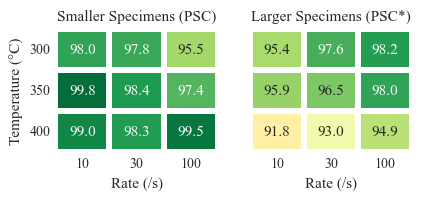

In [33]:
type_analysis_ds = pam.apply_ZH_regression(analysis_ds.copy(), flow_stress_key='flow_Stress(MPa)', group_by='test type')
ax = pam.plot_ZH_regression(type_analysis_ds, group_by='test type', color_by='test type', marker_by='rate',
                            cmap='tab20',
                            flow_stress_key='flow_Stress(MPa)', rate_key='flow_Strain_Rate',
                            temperature_key='flow_temp(K)', figsize=(5, 4), eq_hscale=0.1)
conformance_matrix(type_analysis_ds)